In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from Triplet_CNN_helper import*

/home/ekabuga/.local/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/ekabuga/.local/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to m

In [3]:
class Predictions:
    
    def __init__(self, path_val_test_samples, path_val_samples, path_val_pairs, path_tests, p_arrays, path_preds, shp, bs):
        self.path_val_test_samples = path_val_test_samples
        self.path_val_samples = path_val_samples
        self.path_tests = path_tests
        self.path_val_pairs = path_val_pairs
        self.n1_test = self.path_tests+"n1_test_pairs.csv"
        self.n2_test = self.path_tests+"n2_test_pairs.csv"
        self.n3_test = self.path_tests+"n3_test_pairs.csv"
        self.n1_n2_test = self.path_tests+"n1_n2_test_pairs.csv"
        self.n1_n3_test = self.path_tests+"n1_n3_test_pairs.csv"
        self.n2_n3_test = self.path_tests+"n2_n3_test_pairs.csv"
        self.p_arrays = p_arrays
        self.path_preds = path_preds
        self.bs = bs
        self.shp = shp
        self.evaluator = None
        self.model = None
        
    def evaluation_samples(self, path_test, path_val):
        n1_v = pd.read_csv(path_val)
        n1_t = pd.read_csv(path_test+"n1_test.csv")
        n2_t = pd.read_csv(path_test+"n2_test.csv")
        n3_t = pd.read_csv(path_test+"n3_test.csv")
        df =  pd.concat([n1_v, n1_t, n2_t, n3_t])
        return df.Segment.values
    
    def sample_to_embedding(self, val_test_samples, model):
        testgen = TestGe(val_test_samples, self.shp, self.bs, self.p_arrays, meanvar = True)
        embeddings = model.predict(testgen,verbose=1 )
        return {val_test_samples[i]:embeddings[i] for i in range(len(val_test_samples))}
    
    def optimal_threshold(self, p_val_pairs, sample_2_emb_dict, night):
        
        df_val_pairs = pd.read_csv(p_val_pairs)
        samples_1 = df_val_pairs.sample_1.values
        samples_2 = df_val_pairs.sample_2.values
        labels = df_val_pairs.label.values
        
        embeds_1 = np.array([sample_2_emb_dict[samples_1[i]] for i in range(len(samples_1))])
        embeds_2 = np.array([sample_2_emb_dict[samples_2[i]] for i in range(len(samples_2))])
        
        pre, rec, f1s, acc, thr, dist, preds = self.evaluator.evaluation_metrics(embeds_1, embeds_2, labels, night)
        
        df_val_pairs["Euclid_dist"] = dist
        df_val_pairs["Threshold"] = [thr]*(len(embeds_1))
        df_val_pairs["Predictions"] = preds
        df_val_pairs.to_csv(self.path_preds+night+".csv", index = False)
        
        return pre, rec, f1s, acc, thr
    
    def test_predictions(self, p_test_pairs, sample_2_embed, thr, night = None):
        
        df_test_pairs = pd.read_csv(p_test_pairs)
        samples_1 = df_test_pairs.sample_1.values
        samples_2 = df_test_pairs.sample_2.values
        
        labels = df_test_pairs.label.values
        
        embeds_1 = np.array([sample_2_embed[samples_1[i]] for i in range(len(samples_1))])
        embeds_2 = np.array([sample_2_embed[samples_2[i]] for i in range(len(samples_2))])
        
        P, R, F, A, pair_wise_dists, preds = self.evaluator.mymetrics(embeds_1, embeds_2, labels, thr, night)
        
        df_test_pairs["Euclid_dist"] = pair_wise_dists
        df_test_pairs["Threshold"] = [thr]*(len(embeds_1))
        df_test_pairs["Predictions"] = preds
        df_test_pairs.to_csv(self.path_preds+night+".csv", index = False)
        
        return P, R, F, A
    
    def Execution(self, model):
        
        val_test_samples = self.evaluation_samples(self.path_val_test_samples, self.path_val_samples)
        sample_2_embedding = self.sample_to_embedding(val_test_samples, model)
        pre, rec, f1s, acc, thr = self.optimal_threshold(self.path_val_pairs, sample_2_embedding, "n1_val")
        
        p1, r1, f1, a1 = self.test_predictions(self.n1_test, sample_2_embedding, thr, "n1_test")
        p2, r2, f2, a2 = self.test_predictions(self.n2_test, sample_2_embedding, thr, "n2_test")
        p3, r3, f3, a3 = self.test_predictions(self.n3_test, sample_2_embedding, thr, "n3_test")
        p12, r12, f12, a12 = self.test_predictions(self.n1_n2_test, sample_2_embedding, thr, "n1_n2_test")
        p13, r13, f13, a13 = self.test_predictions(self.n1_n3_test, sample_2_embedding, thr, "n1_n3_test")
        p23, r23, f23, a23 = self.test_predictions(self.n2_n3_test, sample_2_embedding, thr, "n2_n3_test")
        
        metrics = {"n1v":[pre, rec, f1s, acc],
                   "n11":[p1,r1,f1,a1],
                   "n22":[p2, r2, f2, a2],
                   "n33":[p3, r3, f3, a3],
                   "n12":[p12, r12, f12, a12],
                   "n13":[p13, r13, f13, a13],
                   "n23":[p23, r23, f23, a23]
                  }
        
        df = pd.DataFrame.from_dict(metrics, orient = "index", columns = ["precision","recall","f1_score","accuracy"])
        df = df.rename_axis("nights")
        df.to_csv(self.path_preds+"one_metrics.csv")
        
        print("Evaluation has finished")
        return df


2024-10-15 09:02:07.062449: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 09:02:08.233376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14632 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1c:00.0, compute capability: 7.0




Training model has started


++++++++++++++++++++++++++++++++++++++++++++++++++

Epoch 1/30


2024-10-15 09:02:30.639913: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8600
2024-10-15 09:02:31.208812: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2024-10-15 09:02:31.273184: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


4/4 - 26s - loss: 7.2814 - val_loss: 1.0749 - lr: 0.0010 - 26s/epoch - 7s/step
Epoch 2/30
4/4 - 2s - loss: 6.8697 - val_loss: 1.0510 - lr: 0.0010 - 2s/epoch - 476ms/step
Epoch 3/30
4/4 - 2s - loss: 7.1443 - val_loss: 1.0338 - lr: 0.0010 - 2s/epoch - 512ms/step
Epoch 4/30
4/4 - 2s - loss: 6.5999 - val_loss: 1.0271 - lr: 0.0010 - 2s/epoch - 479ms/step
Epoch 5/30
4/4 - 2s - loss: 6.1997 - val_loss: 1.0269 - lr: 0.0010 - 2s/epoch - 469ms/step
Epoch 6/30
4/4 - 2s - loss: 6.0030 - val_loss: 1.0320 - lr: 0.0010 - 2s/epoch - 383ms/step
Epoch 7/30
4/4 - 2s - loss: 5.6154 - val_loss: 1.0326 - lr: 0.0010 - 2s/epoch - 423ms/step
Epoch 8/30
4/4 - 2s - loss: 5.1569 - val_loss: 1.0302 - lr: 0.0010 - 2s/epoch - 426ms/step
Epoch 9/30
4/4 - 2s - loss: 4.4937 - val_loss: 1.0270 - lr: 0.0010 - 2s/epoch - 419ms/step
Epoch 10/30
4/4 - 2s - loss: 3.9528 - val_loss: 1.0237 - lr: 0.0010 - 2s/epoch - 450ms/step
Epoch 11/30
4/4 - 2s - loss: 3.0739 - val_loss: 1.0210 - lr: 0.0010 - 2s/epoch - 470ms/step
Epoch 12/

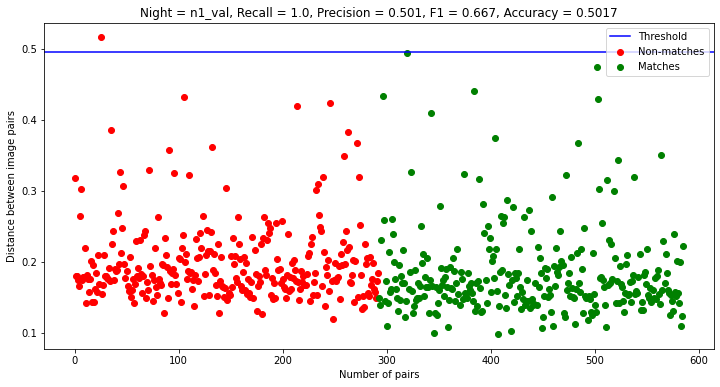

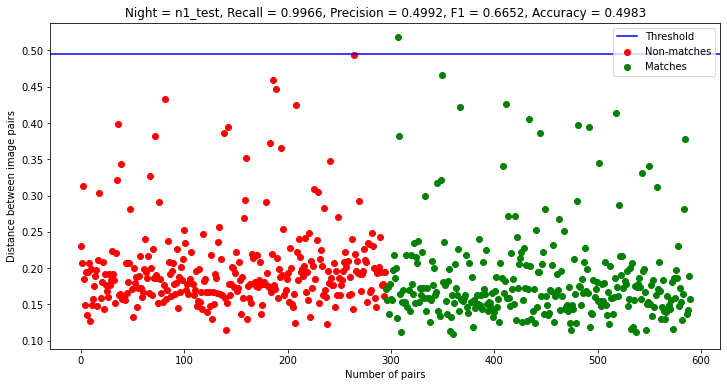

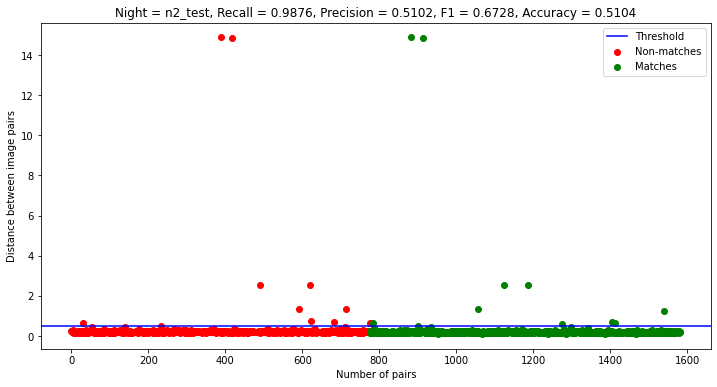

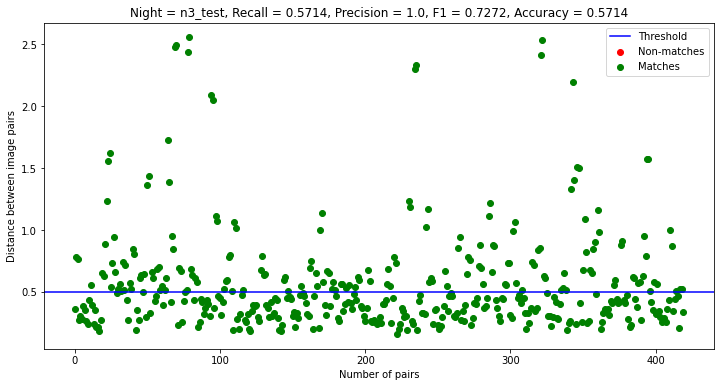

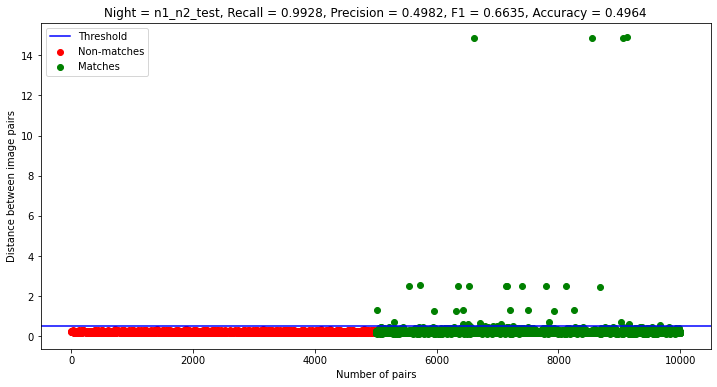

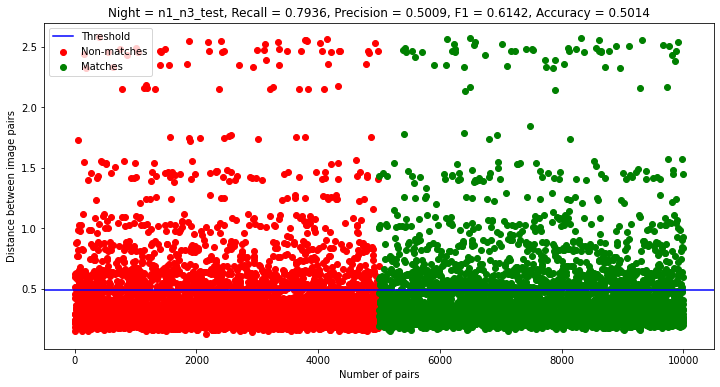

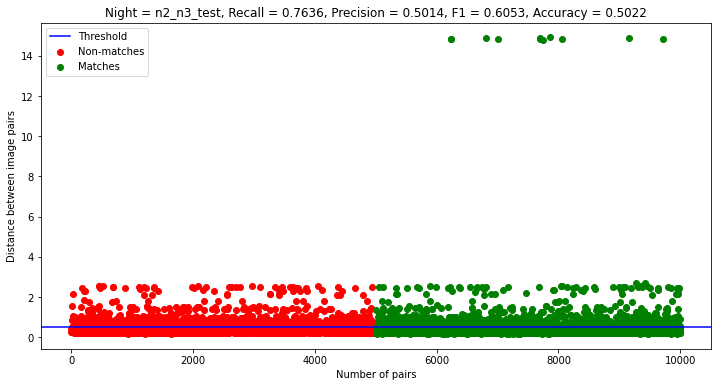

In [4]:
# parameters
Lr = 1e-3
lr = 1e-5
Epochs = 30
shp = (128, 173,1)
batch_size = 256
meanvar = True
samples_per_ID = 16

# paths
p_train = "../githubdata/train_val_test_segment_data/n1_train.csv"
p_v_s = "../githubdata/train_val_test_segment_data/n1_validation.csv"
p_arrays = "../segment_spectrogram_mfcc_feature_extraction/spectrogram_arrays/"
p_weights = "weights/n1_matching.h5"# triplet_n1.h5

p_s = "../githubdata/train_val_test_segment_data/"
p_te = "pairs/"
p_va = p_te+"n1_validation_pairs.csv"
p_p = "matching_predictions/CNNs/"

# Processing
d = DataLoader(p_train, p_v_s, samples_per_ID)
Ts, TYs, Vs, VYs = d.train_validation_samples_labels()
Tgenerator = Generator(Ts, TYs, shp, batch_size, p_arrays, meanvar)
Vgenerator = Generator(Vs, VYs, shp, batch_size, p_arrays, meanvar)
architecture = ModelArchitecture(shp)
trainer = Training()
trainer.architecture = architecture

trainer.Tgenerator = Tgenerator
trainer.Vgenerator = Vgenerator
evaluator = Evaluation()

# training
model = trainer.train(Lr, lr, p_weights, Epochs)
# prediction
predictor = Predictions(p_s, p_v_s, p_va, p_te,p_arrays,p_p, shp, batch_size)
predictor.model = model
predictor.evaluator = evaluator
df = predictor.Execution(model)

